# Training RL agent with LSTM

## Training an agent using PPO (normal and recurrent)

In [1]:
import pfrl
import torch
import torch.nn
import gym
import numpy

import gym_minigrid
import gym_minigrid.wrappers

import matplotlib.pyplot as plt

In [2]:
#env = gym.make('CartPole-v0')
env = gym.make('MiniGrid-MemoryS11-v0')
env = gym_minigrid.wrappers.ImgObsWrapper(env) # Get rid of the 'mission' field
#env = gym_minigrid.wrappers.FlatObsWrapper(env)

print('observation space (shape):', env.observation_space.shape)
print('action space (shape):', env.action_space)

obs = env.reset()

action = env.action_space.sample()
obs, r, done, info = env.step(action)
print('reward:', r)
print('done:', done)
print('info:', info)

# Uncomment to open a GUI window rendering the current state of the environment
# env.render()

observation space (shape): (7, 7, 3)
action space (shape): Discrete(7)
reward: 0
done: False
info: {}


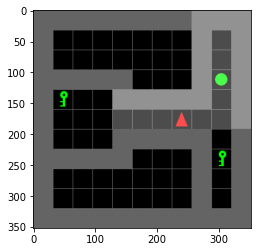

In [3]:
img = env.render("rgb_array")
plt.imshow(img)

In [4]:
obs_size = env.observation_space.low.size
n_actions = env.action_space.n

Create an approximator - a policy-value network (for recurrent must be a cubclass of pfrl.nn.Recurrent)

In [5]:
pv_network = torch.nn.Sequential(
    torch.nn.Linear(obs_size, 128),
    torch.nn.Tanh(),
    torch.nn.Linear(128, 128),
    torch.nn.Tanh(),
    pfrl.nn.Branched(
        torch.nn.Sequential(
            torch.nn.Linear(128, n_actions),
            pfrl.policies.SoftmaxCategoricalHead()
        ),
        torch.nn.Linear(128, 1)
    )
)

In [6]:
pv_network_rec = pfrl.nn.recurrent_sequential.RecurrentSequential(
    torch.nn.Linear(obs_size, 128),
    torch.nn.Tanh(),
    torch.nn.Linear(128, 128),
    torch.nn.Tanh(),
    torch.nn.LSTM(128, 128),
    pfrl.nn.Branched(
        torch.nn.Sequential(
            torch.nn.Linear(128, 128),
            torch.nn.Tanh(),
            torch.nn.Linear(128, n_actions),
            pfrl.policies.SoftmaxCategoricalHead()
        ),
        torch.nn.Sequential(
            torch.nn.Linear(128, 128),
            torch.nn.Tanh(),
            torch.nn.Linear(128, 1)
        )
    )
)

Create an optimizer

In [7]:
optimizer = torch.optim.Adam(pv_network.parameters(), eps=1e-5)

In [8]:
optimizer_rec = torch.optim.Adam(pv_network_rec.parameters(), eps=1e-5)

Some preparations

In [9]:
# Set the discount factor that discounts future rewards.
gamma = 0.99

# Use epsilon-greedy for exploration
explorer = pfrl.explorers.ConstantEpsilonGreedy(
    epsilon=0.3, random_action_func=env.action_space.sample
)

# Observations in MiniGrid are numpy.uint8, but PyTorch only
# accepts numpy.float32 by default, tehrefore we specify
# a converter as a feature extractor function phi.
phi = lambda x: x.astype(numpy.float32, copy=False)

# Set the device id to use GPU. To use CPU only, set it to -1.
gpu = -1

Prepare PPO agents 

In [10]:
agent = pfrl.agents.PPO(
    pv_network,
    optimizer,
    recurrent=False,
    phi=phi,
    gamma=gamma
)

In [11]:
agent_rec = pfrl.agents.PPO(
    pv_network_rec,
    optimizer_rec,
    recurrent=True,
    phi=phi,
    gamma=gamma
)

Train normal agent

In [12]:
n_episodes = 10000
max_episode_len = 200
for i in range(1, n_episodes + 1):
    obs = env.reset()
    obs = obs.flatten()
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while True:
        # Uncomment to watch the behavior in a GUI window
        # env.render()
        action = agent.act(obs)
        obs, reward, done, _ = env.step(action)
        obs = obs.flatten()
        R += reward
        t += 1
        reset = t == max_episode_len
        agent.observe(obs, reward, done, reset)
        if done or reset:
            break
    if i % 100 == 0:
        print('episode:', i, 'R:', R)
    if i % 1000 == 0:
        print('statistics:', agent.get_statistics())
print('Finished.')

episode: 100 R: 0
episode: 200 R: 0.976198347107438
episode: 300 R: 0
episode: 400 R: 0
episode: 500 R: 0
episode: 600 R: 0
episode: 700 R: 0
episode: 800 R: 0
episode: 900 R: 0
episode: 1000 R: 0.9866115702479339
statistics: [('average_value', 0.47324914), ('average_entropy', 1.509029), ('average_value_loss', 0.09772121317684651), ('average_policy_loss', -0.018263580589555205), ('n_updates', 4800), ('explained_variance', -0.005419984917829579)]
episode: 1100 R: 0
episode: 1200 R: 0
episode: 1300 R: 0.9806611570247934
episode: 1400 R: 0.9866115702479339
episode: 1500 R: 0.9836363636363636
episode: 1600 R: 0.9598347107438017
episode: 1700 R: 0
episode: 1800 R: 0.9776859504132231
episode: 1900 R: 0.9895867768595041
episode: 2000 R: 0
statistics: [('average_value', 0.42121455), ('average_entropy', 1.4223869), ('average_value_loss', 0.11399808302521705), ('average_policy_loss', -0.016287857950665056), ('n_updates', 7040), ('explained_variance', -0.028229709180787044)]
episode: 2100 R: 0.98

Test normal agent (no exploration)

In [13]:
with agent.eval_mode():
    for i in range(10):
        obs = env.reset()
        obs = obs.flatten()
        R = 0
        t = 0
        while True:
            # Uncomment to watch the behavior in a GUI window
            # env.render()
            action = agent.act(obs)
            obs, r, done, _ = env.step(action)
            obs = obs.flatten()
            R += r
            t += 1
            reset = t == 200
            agent.observe(obs, r, done, reset)
            if done or reset:
                break
        print('evaluation episode:', i, 'R:', R)

evaluation episode: 0 R: 0.9583471074380165
evaluation episode: 1 R: 0
evaluation episode: 2 R: 0.9851239669421488
evaluation episode: 3 R: 0.9866115702479339
evaluation episode: 4 R: 0
evaluation episode: 5 R: 0.9866115702479339
evaluation episode: 6 R: 0
evaluation episode: 7 R: 0.9702479338842975
evaluation episode: 8 R: 0.9895867768595041
evaluation episode: 9 R: 0


Train agent with recurrent policy-value network

In [14]:
n_episodes = 10000
max_episode_len = 200
for i in range(1, n_episodes + 1):
    obs = env.reset()
    obs = obs.flatten()
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while True:
        # Uncomment to watch the behavior in a GUI window
        # env.render()
        action = agent_rec.act(obs)
        obs, reward, done, _ = env.step(action)
        obs = obs.flatten()
        R += reward
        t += 1
        reset = t == max_episode_len
        agent_rec.observe(obs, reward, done, reset)
        if done or reset:
            break
    if i % 100 == 0:
        print('episode:', i, 'R:', R)
    if i % 1000 == 0:
        print('statistics:', agent_rec.get_statistics())
print('Finished.')

episode: 100 R: 0
episode: 200 R: 0
episode: 300 R: 0.9598347107438017
episode: 400 R: 0
episode: 500 R: 0.9419834710743802
episode: 600 R: 0
episode: 700 R: 0
episode: 800 R: 0.9836363636363636
episode: 900 R: 0.9702479338842975
episode: 1000 R: 0
statistics: [('average_value', 0.41937178), ('average_entropy', 1.2866253), ('average_value_loss', 0.030587906455621122), ('average_policy_loss', -0.0954683216754347), ('n_updates', 7040), ('explained_variance', -0.2726438094525101)]
episode: 1100 R: 0.9583471074380165
episode: 1200 R: 0
episode: 1300 R: 0.9940495867768595
episode: 1400 R: 0.9494214876033058
episode: 1500 R: 0
episode: 1600 R: 0
episode: 1700 R: 0
episode: 1800 R: 0
episode: 1900 R: 0
episode: 2000 R: 0.9628099173553719
statistics: [('average_value', 0.44952422), ('average_entropy', 1.1103649), ('average_value_loss', 0.03230734393233434), ('average_policy_loss', -0.08558076874352992), ('n_updates', 12160), ('explained_variance', 0.01298658143137088)]
episode: 2100 R: 0
episo

Test recurrent PPO agent

In [15]:
with agent_rec.eval_mode():
    for i in range(10):
        obs = env.reset()
        obs = obs.flatten()
        R = 0
        t = 0
        while True:
            # Uncomment to watch the behavior in a GUI window
            # env.render()
            action = agent_rec.act(obs)
            obs, r, done, _ = env.step(action)
            obs = obs.flatten()
            R += r
            t += 1
            reset = t == 200
            agent_rec.observe(obs, r, done, reset)
            if done or reset:
                break
        print('evaluation episode:', i, 'R:', R)

evaluation episode: 0 R: 0.9598347107438017
evaluation episode: 1 R: 0
evaluation episode: 2 R: 0.9821487603305785
evaluation episode: 3 R: 0.9747107438016529
evaluation episode: 4 R: 0
evaluation episode: 5 R: 0
evaluation episode: 6 R: 0.903305785123967
evaluation episode: 7 R: 0.988099173553719
evaluation episode: 8 R: 0
evaluation episode: 9 R: 0
